KELOMPOK 4:

1.   KEFAS AZARYA - 235091000111005
2.   CINTA AMALIA PUTRI - 235091001111007
3.   ZAHIDAH NAJLA NUR AFIFAH - 235091007111002
4.   SHABRINA DESLOVEY ASMARA - 235091007111008

**IMPORT LIBRARIES**

In [ ]:
# Import library penting PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
import pandas as pd

# MEMBUAT SPARK SESSION
spark = SparkSession.builder \
    .appName("BigDataSalesAnalysis") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

# Tampilkan session
spark

**UPLOAD DATASET DAN DATA PROFILING**

In [ ]:
df = spark.read.csv("/content/sales_data_sample.csv",
                    header=True,
                    inferSchema=True)

# Cek struktur kolom & tipe data
print("Struktur Kolom dan Tipe Data:")
df.printSchema()

# Lihat 5 baris awal
print("5 Baris Awal Dataframe:")
df.show(5)

# Hitung jumlah baris data
print("Jumlah baris data:")
df.count()

Struktur Kolom dan Tipe Data:
root
 |-- ORDERNUMBER: integer (nullable = true)
 |-- QUANTITYORDERED: integer (nullable = true)
 |-- PRICEEACH: double (nullable = true)
 |-- ORDERLINENUMBER: integer (nullable = true)
 |-- SALES: double (nullable = true)
 |-- ORDERDATE: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- QTR_ID: integer (nullable = true)
 |-- MONTH_ID: integer (nullable = true)
 |-- YEAR_ID: integer (nullable = true)
 |-- PRODUCTLINE: string (nullable = true)
 |-- MSRP: integer (nullable = true)
 |-- PRODUCTCODE: string (nullable = true)
 |-- CUSTOMERNAME: string (nullable = true)
 |-- PHONE: string (nullable = true)
 |-- ADDRESSLINE1: string (nullable = true)
 |-- ADDRESSLINE2: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- POSTALCODE: string (nullable = true)
 |-- COUNTRY: string (nullable = true)
 |-- TERRITORY: string (nullable = true)
 |-- CONTACTLASTNAME: string (nullable = true)
 |-- CONTACTFI

2823

**DATA CLEANING**

In [ ]:
#Cek Missing Values
for c in df.columns:
  print(c, "=>", df.filter((col(c).isNull()) | (col(c) == "NULL") | (col(c) == "")).count())

df_clean = df

# Replace 'NULL' with actual null
for c in df_clean.columns:
  df_clean = df_clean.withColumn(c, when(col(c) == "NULL", None).otherwise(col(c)))

ORDERNUMBER => 0
QUANTITYORDERED => 0
PRICEEACH => 0
ORDERLINENUMBER => 0
SALES => 0
ORDERDATE => 0
STATUS => 0
QTR_ID => 0
MONTH_ID => 0
YEAR_ID => 0
PRODUCTLINE => 0
MSRP => 0
PRODUCTCODE => 0
CUSTOMERNAME => 0
PHONE => 0
ADDRESSLINE1 => 0
ADDRESSLINE2 => 2521
CITY => 0
STATE => 1486
POSTALCODE => 76
COUNTRY => 0
TERRITORY => 0
CONTACTLASTNAME => 0
CONTACTFIRSTNAME => 0
DEALSIZE => 0


In [ ]:
# Drop rows dengan missing value di kolom penting
important_cols = ["ORDERNUMBER", "QUANTITYORDERED", "PRICEEACH", "SALES", "ORDERDATE", "PRODUCTLINE"]
df_clean = df_clean.dropna(subset=important_cols)

# Convert ORDERDATE ke date
df_clean = df_clean.withColumn("ORDERDATE", to_timestamp(col("ORDERDATE"), "M/d/yyyy H:mm"))

# Cast numerik
num_cols = ["QUANTITYORDERED", "PRICEEACH", "SALES", "MSRP"]
for c in num_cols:
  df_clean = df_clean.withColumn(c, col(c).cast("double"))

# Cleaning duplikasi
df_clean = df_clean.dropDuplicates()
print("Setelah cleaning:", df_clean.count())

df_clean.show(5)

Setelah cleaning: 2823
+-----------+---------------+---------+---------------+-------+-------------------+-------+------+--------+-------+------------+-----+-----------+--------------------+------------+-----------------+------------+------------+--------+----------+---------+---------+---------------+----------------+--------+
|ORDERNUMBER|QUANTITYORDERED|PRICEEACH|ORDERLINENUMBER|  SALES|          ORDERDATE| STATUS|QTR_ID|MONTH_ID|YEAR_ID| PRODUCTLINE| MSRP|PRODUCTCODE|        CUSTOMERNAME|       PHONE|     ADDRESSLINE1|ADDRESSLINE2|        CITY|   STATE|POSTALCODE|  COUNTRY|TERRITORY|CONTACTLASTNAME|CONTACTFIRSTNAME|DEALSIZE|
+-----------+---------------+---------+---------------+-------+-------------------+-------+------+--------+-------+------------+-----+-----------+--------------------+------------+-----------------+------------+------------+--------+----------+---------+---------+---------------+----------------+--------+
|      10223|           29.0|    100.0|              8|3

In [ ]:
#Buat kolom Revenue Total
df_clean = df_clean.withColumn("TOTAL_REVENUE", col("QUANTITYORDERED") * col("PRICEEACH"))
df_clean.show(5)

+-----------+---------------+---------+---------------+-------+-------------------+-------+------+--------+-------+------------+-----+-----------+--------------------+------------+-----------------+------------+------------+--------+----------+---------+---------+---------------+----------------+--------+------------------+
|ORDERNUMBER|QUANTITYORDERED|PRICEEACH|ORDERLINENUMBER|  SALES|          ORDERDATE| STATUS|QTR_ID|MONTH_ID|YEAR_ID| PRODUCTLINE| MSRP|PRODUCTCODE|        CUSTOMERNAME|       PHONE|     ADDRESSLINE1|ADDRESSLINE2|        CITY|   STATE|POSTALCODE|  COUNTRY|TERRITORY|CONTACTLASTNAME|CONTACTFIRSTNAME|DEALSIZE|     TOTAL_REVENUE|
+-----------+---------------+---------+---------------+-------+-------------------+-------+------+--------+-------+------------+-----+-----------+--------------------+------------+-----------------+------------+------------+--------+----------+---------+---------+---------------+----------------+--------+------------------+
|      10223|         

In [ ]:
#Buat kolom tahun dan bulan untuk analisis trend# Extract year, month
df_clean = df_clean.withColumn("YEAR", year(col("ORDERDATE")))
df_clean = df_clean.withColumn("MONTH", month(col("ORDERDATE")))
df_clean.show(5)

+-----------+---------------+---------+---------------+-------+-------------------+-------+------+--------+-------+------------+-----+-----------+--------------------+------------+-----------------+------------+------------+--------+----------+---------+---------+---------------+----------------+--------+------------------+----+-----+
|ORDERNUMBER|QUANTITYORDERED|PRICEEACH|ORDERLINENUMBER|  SALES|          ORDERDATE| STATUS|QTR_ID|MONTH_ID|YEAR_ID| PRODUCTLINE| MSRP|PRODUCTCODE|        CUSTOMERNAME|       PHONE|     ADDRESSLINE1|ADDRESSLINE2|        CITY|   STATE|POSTALCODE|  COUNTRY|TERRITORY|CONTACTLASTNAME|CONTACTFIRSTNAME|DEALSIZE|     TOTAL_REVENUE|YEAR|MONTH|
+-----------+---------------+---------+---------------+-------+-------------------+-------+------+--------+-------+------------+-----+-----------+--------------------+------------+-----------------+------------+------------+--------+----------+---------+---------+---------------+----------------+--------+------------------+-

**AGGREGATION & EDA**

Tabel Produk Terlaris:
+----------------+----------+
|     PRODUCTLINE|TOTAL_SOLD|
+----------------+----------+
|    Classic Cars|   33992.0|
|    Vintage Cars|   21069.0|
|     Motorcycles|   11663.0|
|Trucks and Buses|   10777.0|
|          Planes|   10727.0|
|           Ships|    8127.0|
|          Trains|    2712.0|
+----------------+----------+

Visualisasi Produk Terlaris:


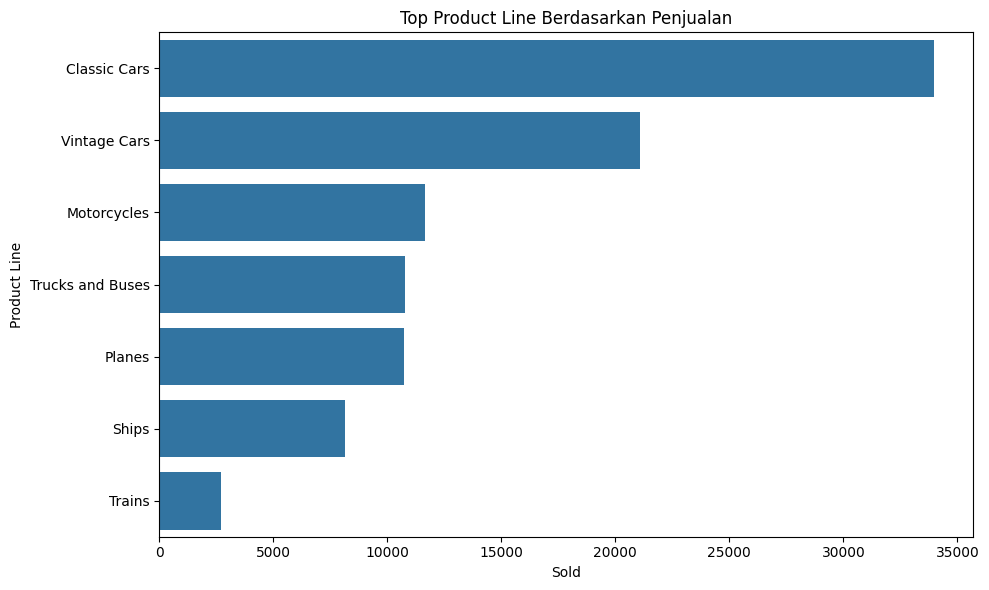

In [ ]:
# Produk Terlaris
top_products = df_clean.groupBy("PRODUCTLINE") \
    .agg(sum("QUANTITYORDERED").alias("TOTAL_SOLD")) \
    .orderBy(col("TOTAL_SOLD").desc())

print ("Tabel Produk Terlaris:")
top_products.show()

pdf_product = top_products.toPandas()

plt.figure(figsize=(10,6))
sns.barplot(data=pdf_product, x="TOTAL_SOLD", y="PRODUCTLINE")
plt.title("Top Product Line Berdasarkan Penjualan")
plt.xlabel("Sold")
plt.ylabel("Product Line")
plt.tight_layout()

print ("Visualisasi Produk Terlaris:")
plt.show()

Tabel Penjualan Per-Produk:
+----------------+------------------+
|     PRODUCTLINE| TOTAL_REVENUE_SUM|
+----------------+------------------+
|    Classic Cars| 2968546.399999997|
|    Vintage Cars|1644212.0500000003|
|     Motorcycles| 971086.2900000002|
|Trucks and Buses| 947355.1800000002|
|          Planes| 877942.2099999997|
|           Ships| 677940.4000000003|
|          Trains|203804.25999999995|
+----------------+------------------+

Visualisasi Penjualan Per-Produk:


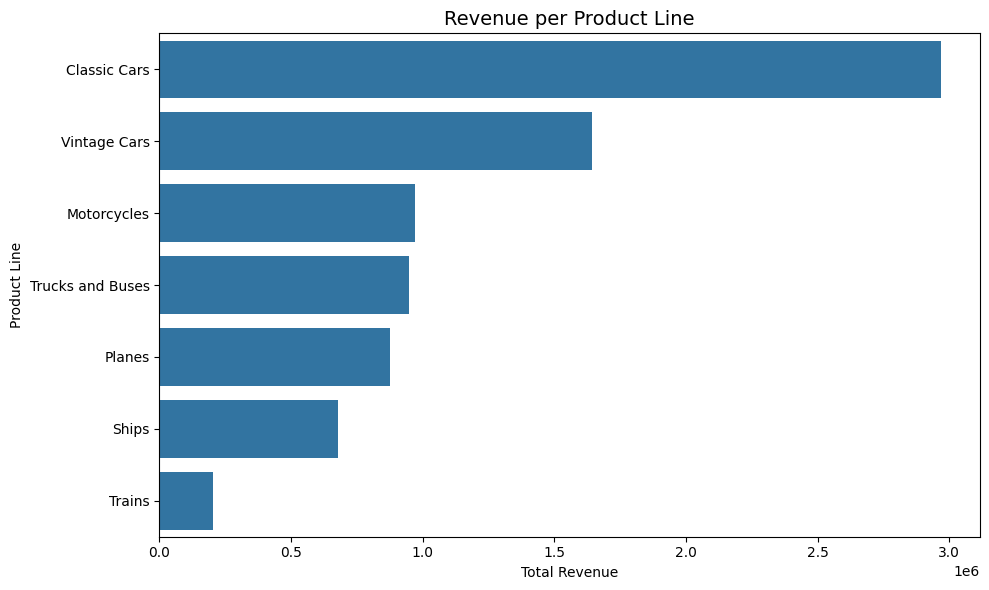

In [ ]:
#Revenue per product line
top_rev_product = df_clean.groupBy("PRODUCTLINE") \
    .agg(sum("TOTAL_REVENUE").alias("TOTAL_REVENUE_SUM")) \
    .orderBy(col("TOTAL_REVENUE_SUM").desc())

print ("Tabel Penjualan Per-Produk:")
top_rev_product.show()

# Convert to pandas
pdf_product = top_rev_product.toPandas()

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=pdf_product,
    x="TOTAL_REVENUE_SUM",
    y="PRODUCTLINE"
)

plt.title("Revenue per Product Line", fontsize=14)
plt.xlabel("Total Revenue")
plt.ylabel("Product Line")
plt.tight_layout()

print ("Visualisasi Penjualan Per-Produk:")
plt.show()

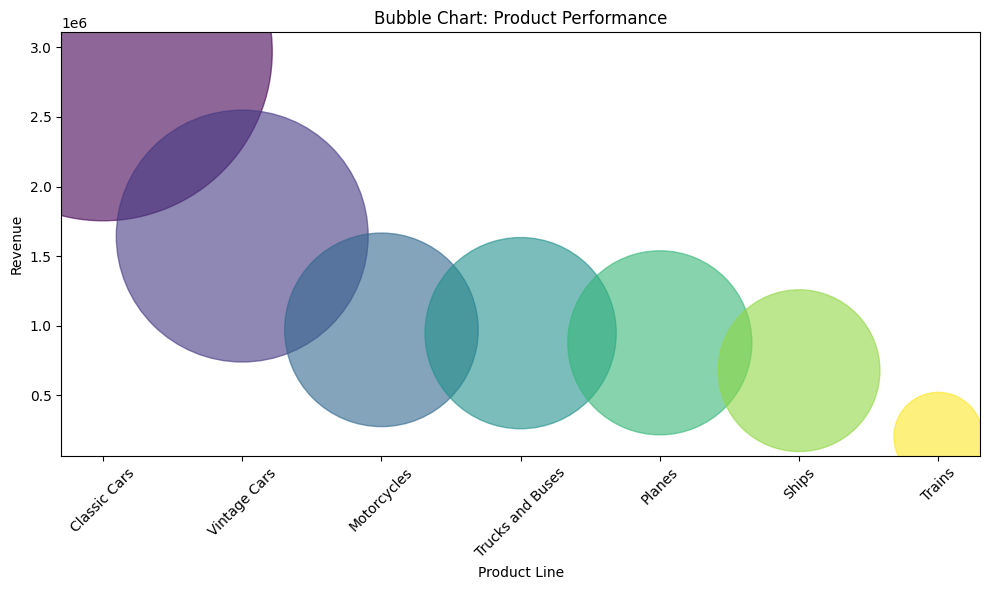

In [ ]:
#Product Performance
pdf_bubble = top_rev_product.toPandas()

plt.figure(figsize=(10,6))
plt.scatter(
    pdf_bubble["PRODUCTLINE"],
    pdf_bubble["TOTAL_REVENUE_SUM"],
    s=pdf_bubble["TOTAL_REVENUE_SUM"]/50,   # ukuran bubble
    alpha=0.6,
    c=range(len(pdf_bubble)), cmap="viridis"
)

plt.title("Bubble Chart: Product Performance")
plt.xlabel("Product Line")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Tabel Penjualan Per-Negara:
+-----------+------------------+
|    COUNTRY|     TOTAL_REVENUE|
+-----------+------------------+
|        USA|2986425.2099999995|
|      Spain|        1021705.97|
|     France|         919257.85|
|  Australia|521598.45999999996|
|         UK| 413203.3399999999|
|      Italy|309402.86999999994|
|    Finland|          268714.7|
|     Norway|246115.80000000002|
|  Singapore|          227985.5|
|     Canada|         193504.34|
|    Denmark|         192747.63|
|    Germany|178689.08000000002|
|     Sweden|174264.10000000003|
|    Austria|172793.05000000002|
|      Japan|153076.69000000003|
|    Belgium| 94528.87999999999|
|Switzerland| 93344.91000000002|
|Philippines|          80291.17|
|    Ireland|          43237.24|
+-----------+------------------+



/tmp/ipython-input-3636071734.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="TOTAL_REVENUE", y="COUNTRY", data=pdf_country, palette="magma")


Visualisasi Penjualan Per-Negara:


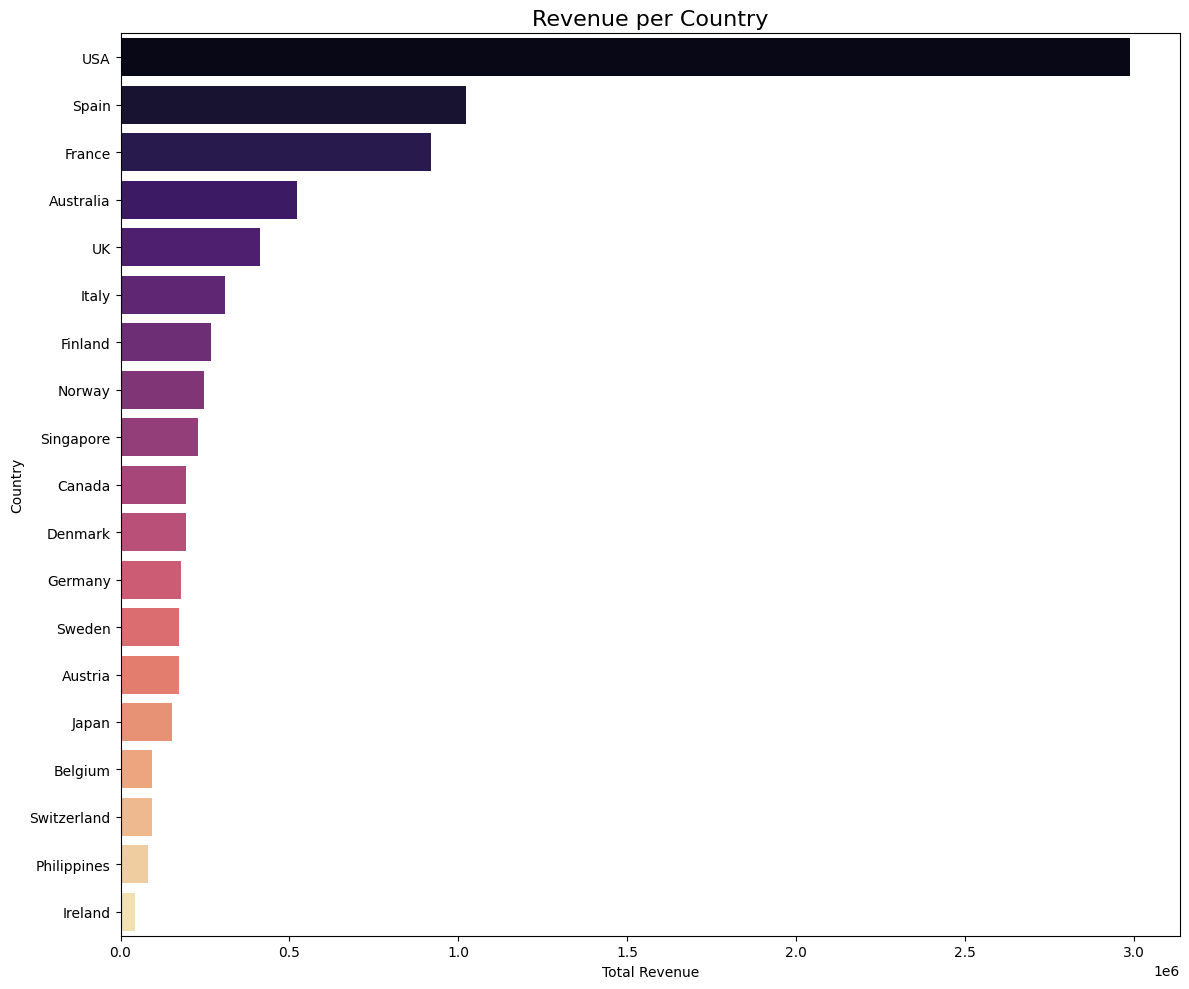

In [ ]:
#Revenue per negara
sales_country = df_clean.groupBy("COUNTRY") \
    .agg(sum("TOTAL_REVENUE").alias("TOTAL_REVENUE")) \
    .orderBy(col("TOTAL_REVENUE").desc())

print ("Tabel Penjualan Per-Negara:")
sales_country.show()

pdf_country = sales_country.toPandas()

plt.figure(figsize=(12,10))
sns.barplot(x="TOTAL_REVENUE", y="COUNTRY", data=pdf_country, palette="magma")

plt.title("Revenue per Country", fontsize=16)
plt.xlabel("Total Revenue")
plt.ylabel("Country")
plt.tight_layout()

print ("Visualisasi Penjualan Per-Negara:")
plt.show()

Tabel Customer Penjualan Tertinggi:
+--------------------+------------------+
|        CUSTOMERNAME|     TOTAL_REVENUE|
+--------------------+------------------+
|Euro Shopping Cha...|         766195.05|
|Mini Gifts Distri...| 530587.1900000002|
|Australian Collec...|164575.87000000002|
|   La Rochelle Gifts|         153909.82|
|  Muscle Machine Inc|151782.03999999998|
|   Land of Toys Inc.|138798.16999999998|
|      AV Stores, Co.|136873.24999999997|
|The Sharp Gifts W...|         136383.04|
|Souveniers And Th...|         133223.38|
|Dragon Souveniers...|         131279.95|
|       Rovelli Gifts|127143.64000000003|
|Salzburg Collecta...|         126287.85|
|Anna's Decoration...|         121260.41|
|Corporate Gift Id...|         118844.95|
|Saveley & Henriot...|118580.23000000003|
|  Reims Collectables|116502.73000000001|
|Scandinavian Gift...|115889.88999999998|
|Danish Wholesale ...|115268.83999999998|
| L'ordine Souveniers|109614.21999999999|
|Technics Stores Inc.|         102489.13

/tmp/ipython-input-754910537.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="TOTAL_REVENUE", y="CUSTOMERNAME", data=pdf_cust, palette="magma")


Visualisasi Customer Penjualan Tertinggi:


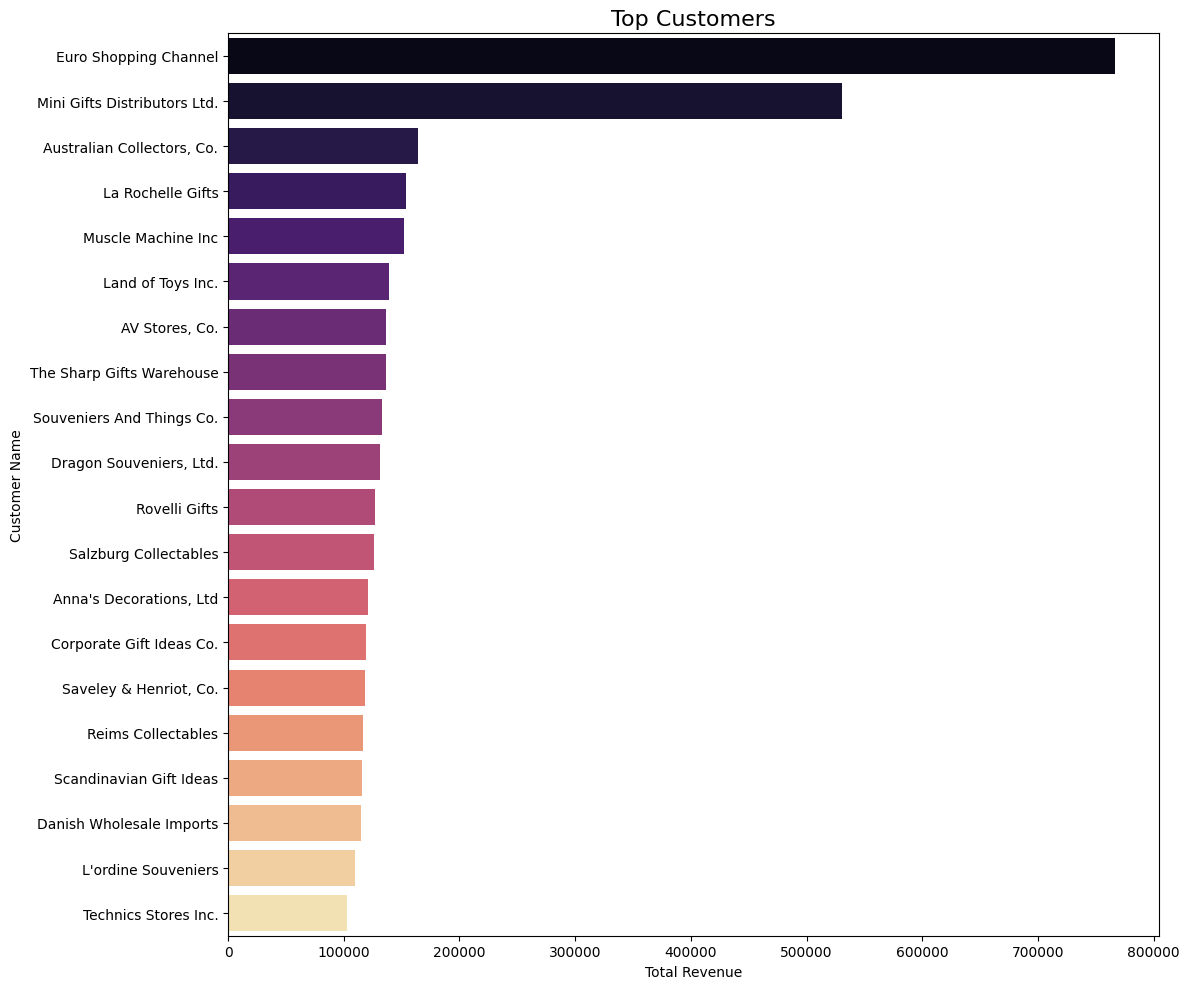

In [ ]:
#Customer dengan Revenue tertinggi
top_customers = df_clean.groupBy("CUSTOMERNAME") \
    .agg(sum("TOTAL_REVENUE").alias("TOTAL_REVENUE")) \
    .orderBy(col("TOTAL_REVENUE").desc()) \
    .limit(20)

print ("Tabel Customer Penjualan Tertinggi:")
top_customers.show()

pdf_cust = top_customers.toPandas()

plt.figure(figsize=(12,10))
sns.barplot(x="TOTAL_REVENUE", y="CUSTOMERNAME", data=pdf_cust, palette="magma")

plt.title("Top Customers", fontsize=16)
plt.xlabel("Total Revenue")
plt.ylabel("Customer Name")
plt.tight_layout()

print ("Visualisasi Customer Penjualan Tertinggi:")
plt.show()

Tabel Tren Revenue per Bulan:
+----+-----+------------------+
|YEAR|MONTH|   MONTHLY_REVENUE|
+----+-----+------------------+
|2003|    1|107885.95999999999|
|2003|    2|120036.79999999999|
|2003|    3|144096.22999999998|
|2003|    4|         169421.03|
|2003|    5|163654.11999999997|
|2003|    6|139552.84000000003|
|2003|    7|149869.72999999995|
|2003|    8|         166026.32|
|2003|    9|         211045.86|
|2003|   10|466240.56999999995|
|2003|   11|         850203.27|
|2003|   12|         210117.21|
|2004|    1|268015.86999999994|
|2004|    2|         258389.05|
|2004|    3|166958.55999999997|
|2004|    4|172935.80000000005|
|2004|    5|220815.13999999998|
|2004|    6|         245190.75|
|2004|    7|271103.61000000004|
|2004|    8| 386106.5900000001|
|2004|    9|         263854.26|
|2004|   10|         452796.13|
|2004|   11| 894479.1799999998|
|2004|   12| 313055.9299999999|
|2005|    1| 283680.4599999999|
|2005|    2|289902.30000000005|
|2005|    3|         315131.94|
|2005|    

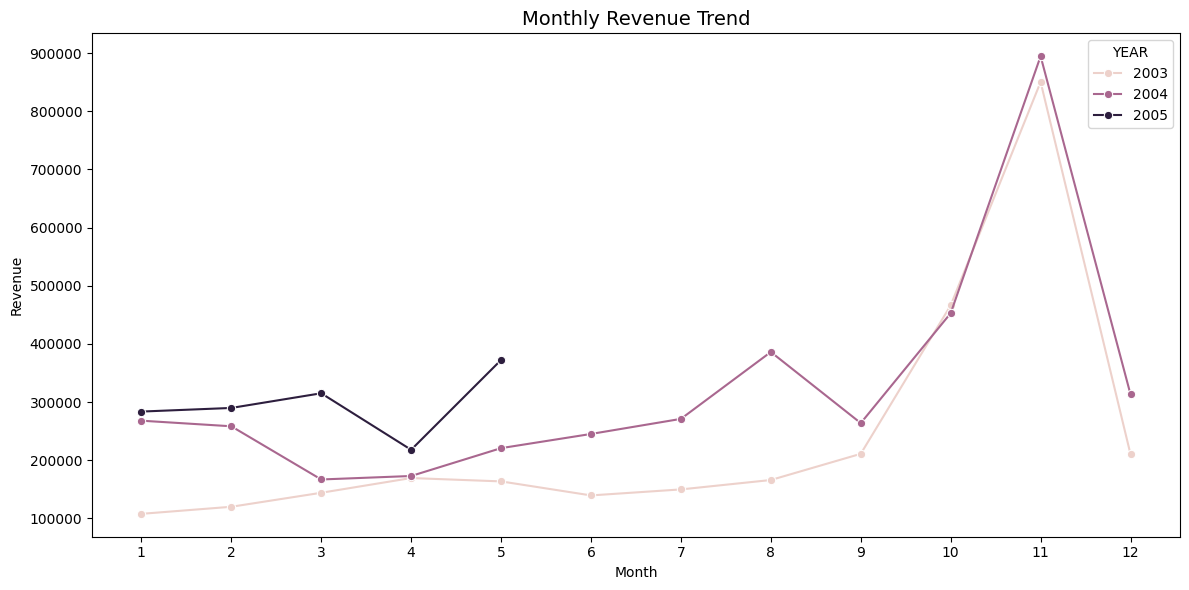

In [ ]:
#Tren revenue per bulan dalam setiap tahun
monthly_trend = df_clean.groupBy("YEAR", "MONTH") \
    .agg(sum("TOTAL_REVENUE").alias("MONTHLY_REVENUE")) \
    .orderBy("YEAR", "MONTH")

print ("Tabel Tren Revenue per Bulan:")
monthly_trend.show(40)

pdf_month = monthly_trend.toPandas()
pdf_month = pdf_month.sort_values(["YEAR", "MONTH"])

plt.figure(figsize=(12,6))
sns.lineplot(x="MONTH", y="MONTHLY_REVENUE", hue="YEAR", data=pdf_month, marker="o")

plt.title("Monthly Revenue Trend", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(range(1,13))
plt.tight_layout()

print ("Visualisasi Tren Revenue per Bulan:")
plt.show()

**K-MEANS CLUSTERING**

In [ ]:
# Pilih fitur numerik
features = ["QUANTITYORDERED", "PRICEEACH", "SALES", "MSRP", "TOTAL_REVENUE"]
assembler = VectorAssembler(inputCols=features, outputCol="features_raw")
scaler = StandardScaler(inputCol="features_raw", outputCol="scaledFeatures")

In [ ]:
# K-Means Modelling
kmeans = KMeans(k=3, featuresCol="scaledFeatures", seed=42)
pipeline = Pipeline(stages=[assembler, scaler, kmeans])
model = pipeline.fit(df_clean)
pred = model.transform(df_clean)

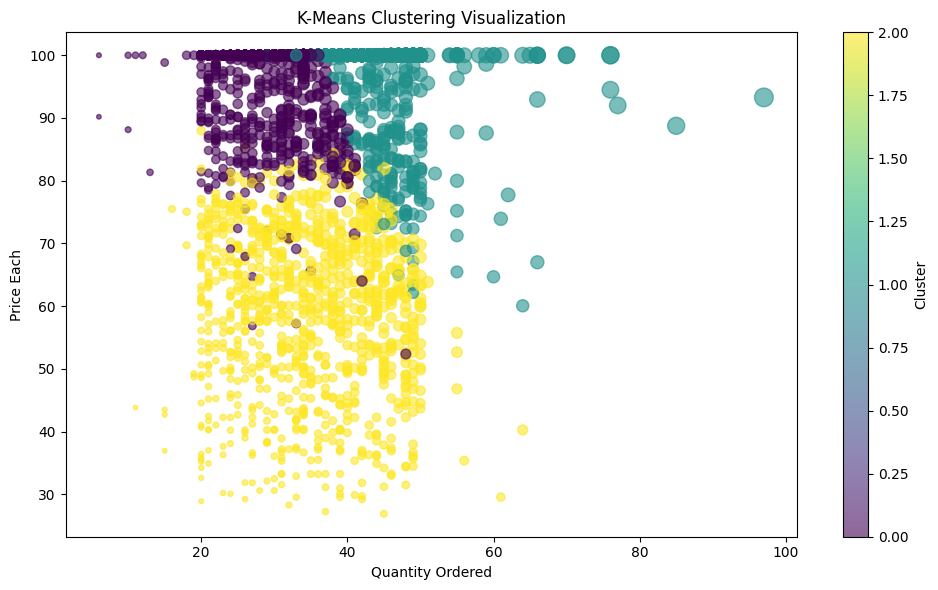

In [ ]:
# Visualisasi
pdf_cluster = pred.select(
    "QUANTITYORDERED",
    "PRICEEACH",
    "TOTAL_REVENUE",
    "prediction"
).toPandas()

# Plotting
plt.figure(figsize=(10,6))
plt.scatter(
    pdf_cluster["QUANTITYORDERED"],
    pdf_cluster["PRICEEACH"],
    c=pdf_cluster["prediction"],
    s=pdf_cluster["TOTAL_REVENUE"] / 50,   # bubble size
    cmap="viridis",
    alpha=0.6
)

plt.title("K-Means Clustering Visualization")
plt.xlabel("Quantity Ordered")
plt.ylabel("Price Each")
plt.colorbar(label="Cluster")
plt.tight_layout()
plt.show()


**EVALUASI MODEL**

In [ ]:
# Evaluasi
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator(featuresCol="scaledFeatures")
sil = evaluator.evaluate(pred)
print("Silhouette Score:", sil)

Silhouette Score: 0.5216506259770505


**EXPORT DATASET OLAHAN**

In [ ]:
# ====== EXPORT df_clean sebagai 1 file CSV ======

# 1. Simpan df_clean jadi 1 CSV (pakai coalesce)
export_path = "/content/df_clean_export"
df_clean.coalesce(1).write.mode("overwrite").csv(export_path, header=True)

print("File saved to:", export_path)

# 2. Cari nama file CSV yang baru dibuat
import glob
csv_file = glob.glob(export_path + "/*.csv")[0]
print("CSV file found:", csv_file)

# 3. Download file ke komputer
from google.colab import files
files.download(csv_file)

print("Download complete!")

File saved to: /content/df_clean_export
CSV file found: /content/df_clean_export/part-00000-b2620b1f-8581-4e7f-aab4-f4aeaf8e03ba-c000.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download complete!
